In [3]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving models and preprocessors
import os
from datetime import datetime # For feature engineering

# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # LabelEncoder for target
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Model Algorithm (Example: XGBoost Classifier)
import xgboost as xgb

# --- Configuration ---
MODEL_NAME_PREFIX = "ontime" # Used for naming saved files
TARGET_COLUMN = "OnTimePerformance" # This is our categorical target
DATA_PATH = '../data/TAS_Airport_Data_2024_cleaned_exploratory.csv'
MODELS_DIR = '../models/'
MODELS_META_DIR = '../models_meta/'

# Create directories if they don't exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(MODELS_META_DIR, exist_ok=True)


# CRISP-DM Phase: Data Understanding (Brief Recap) & Preparation

In [4]:
# 1. Load Data
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
df.columns = df.columns.str.strip()

# 2. Define/Prepare Target Variable (y) and Initial Features (X_initial)
if TARGET_COLUMN not in df.columns:
    # If 'OnTimePerformance' doesn't exist, derive it from 'ArrivalDelay'
    if 'ArrivalDelay' in df.columns:
        print(f"'{TARGET_COLUMN}' not found. Deriving from 'ArrivalDelay'.")
        # Example: Binary classification (On-Time if delay <= 15 min)
        df[TARGET_COLUMN] = np.where(df['ArrivalDelay'] <= 15, "On-Time", "Delayed")
        print(f"Derived '{TARGET_COLUMN}' based on ArrivalDelay <= 15 minutes.")
    else:
        raise ValueError(f"Target column '{TARGET_COLUMN}' not found and cannot derive without 'ArrivalDelay'.")

# Drop rows where target is NaN (e.g., if derived from ArrivalDelay which had NaNs)
df.dropna(subset=[TARGET_COLUMN], inplace=True)
df[TARGET_COLUMN] = df[TARGET_COLUMN].astype(str) # Ensure it's string for LabelEncoder
print(f"Shape after dropping NaNs in target '{TARGET_COLUMN}': {df.shape}")
print(f"Unique values in '{TARGET_COLUMN}': {df[TARGET_COLUMN].unique()}")
print(df[TARGET_COLUMN].value_counts())

num_target_classes = df[TARGET_COLUMN].nunique()

# Label Encode the Target Variable
le_ontime = LabelEncoder()
y_encoded = le_ontime.fit_transform(df[TARGET_COLUMN])

# Save the label encoder
label_encoder_filename_ontime = f"label_encoder_{MODEL_NAME_PREFIX}.pkl"
label_encoder_path_ontime = os.path.join(MODELS_META_DIR, label_encoder_filename_ontime)
joblib.dump(le_ontime, label_encoder_path_ontime)
print(f"Label encoder for OnTimePerformance saved to: {label_encoder_path_ontime}")
print(f"Target classes: {list(le_ontime.classes_)}")


y = pd.Series(y_encoded, index=df.index)

# Drop target, ID, and other potential leakages/outcomes
# ArrivalDelay is dropped because OnTimePerformance is often derived directly from it.
# DepartureDelay could be kept if it's a known input.
X_initial = df.drop(columns=[TARGET_COLUMN, 'FlightID', 'ReasonForDelay', 'ArrivalDelay', 'Gate'])

# 3. Feature Engineering (Similar to Arrival Delay model)
print("\n--- Feature Engineering ---")

# Datetime features from 'ScheduledArrivalTime'
if 'ScheduledArrivalTime' in X_initial.columns:
    X_initial['ScheduledArrivalTime'] = pd.to_datetime(X_initial['ScheduledArrivalTime'], errors='coerce')
    X_initial['SchArr_Hour'] = X_initial['ScheduledArrivalTime'].dt.hour
    X_initial['SchArr_DayOfWeek'] = X_initial['ScheduledArrivalTime'].dt.dayofweek
    X_initial['SchArr_Month'] = X_initial['ScheduledArrivalTime'].dt.month
    X_initial['SchArr_Is_Weekend'] = X_initial['ScheduledArrivalTime'].dt.dayofweek.isin([5, 6]).astype(int)
    X_initial = X_initial.drop(columns=['ScheduledArrivalTime'])
    print("Engineered datetime features from ScheduledArrivalTime.")

# Datetime features from 'ScheduledTime' (Departure Time)
if 'ScheduledTime' in X_initial.columns:
    X_initial['ScheduledTime'] = pd.to_datetime(X_initial['ScheduledTime'], errors='coerce')
    X_initial['SchDep_Hour'] = X_initial['ScheduledTime'].dt.hour
    X_initial['SchDep_DayOfWeek'] = X_initial['ScheduledTime'].dt.dayofweek
    X_initial['SchDep_Month'] = X_initial['ScheduledTime'].dt.month
    X_initial = X_initial.drop(columns=['ScheduledTime'])
    print("Engineered datetime features from ScheduledTime (Departure).")

# Ensure 'DepartureDelay' (if used as feature) is numeric
if 'DepartureDelay' in X_initial.columns:
    X_initial['DepartureDelay'] = pd.to_numeric(X_initial['DepartureDelay'], errors='coerce')

# Align X and y
X_initial = X_initial.loc[y.index]
print(f"Shape of X_initial after feature engineering: {X_initial.shape}")
print(f"Shape of y after aligning: {y.shape}")

# 4. Identify Feature Types for Preprocessing
numerical_features = X_initial.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_initial.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"\nIdentified Numerical Features: {numerical_features}")
print(f"Identified Categorical Features: {categorical_features}")

# 5. Split Data into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_initial, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

# 6. Create Preprocessing Pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

active_numerical_features = [col for col in numerical_features if col in X_train.columns]
active_categorical_features = [col for col in categorical_features if col in X_train.columns]

preprocessor_ontime = ColumnTransformer([
    ('num', numerical_pipeline, active_numerical_features),
    ('cat', categorical_pipeline, active_categorical_features)
], remainder='drop')




Shape after dropping NaNs in target 'OnTimePerformance': (32940, 32)
Unique values in 'OnTimePerformance': ['Delayed' 'OnTime']
OnTimePerformance
Delayed    18117
OnTime     14823
Name: count, dtype: int64
Label encoder for OnTimePerformance saved to: ../models_meta/label_encoder_ontime.pkl
Target classes: ['Delayed', 'OnTime']

--- Feature Engineering ---
Engineered datetime features from ScheduledArrivalTime.
Engineered datetime features from ScheduledTime (Departure).
Shape of X_initial after feature engineering: (32940, 32)
Shape of y after aligning: (32940,)

Identified Numerical Features: ['FlightDuration', 'BaggageHandlers', 'GroundCrew', 'FuelTrucks', 'CleaningCrew', 'Passengers', 'SecurityChecks', 'RunwayDelay', 'DepartureDelay', 'PreviousFlightDelay', 'AircraftTurnaroundTime', 'CheckInQueueTime', 'SecurityWaitTime', 'BaggageClaimBelts', 'CustomsOfficers', 'ImmigrationOfficers', 'SchArr_Hour', 'SchArr_DayOfWeek', 'SchArr_Month', 'SchArr_Is_Weekend', 'SchDep_Hour', 'SchDep_DayO

# CRISP-DM Phase: Modeling 

In [5]:


# 7. Fit the Preprocessor on the Training Data
print("\n--- Fitting Preprocessor ---")
X_train_processed_np = preprocessor_ontime.fit_transform(X_train)
feature_names_processed_ontime = list(preprocessor_ontime.get_feature_names_out())
X_train_processed = pd.DataFrame(X_train_processed_np, columns=feature_names_processed_ontime, index=X_train.index)
print(f"Shape of X_train_processed: {X_train_processed.shape}")

# Transform the Test Data
X_test_processed_np = preprocessor_ontime.transform(X_test)
X_test_processed = pd.DataFrame(X_test_processed_np, columns=feature_names_processed_ontime, index=X_test.index)
print(f"Shape of X_test_processed: {X_test_processed.shape}")


# 8. Define and Train the Model (XGBoost Classifier)
print("\n--- Model Training ---")

# Determine objective based on number of classes
objective = 'binary:logistic' if num_target_classes == 2 else 'multi:softmax'
eval_metric = 'logloss' if num_target_classes == 2 else 'mlogloss' # merror is also an option for multiclass

xgb_clf_ontime = xgb.XGBClassifier(
    objective=objective,
    num_class=num_target_classes if num_target_classes > 2 else None, # Only for multi:softmax if > 2 classes
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric=eval_metric,
    use_label_encoder=False # We explicitly label encoded y
)

# Fit model (consider early stopping for XGBoost)
# xgb_clf_ontime.fit(X_train_processed, y_train,
#                    eval_set=[(X_test_processed, y_test)],
#                    early_stopping_rounds=10, # Example
#                    verbose=False)

xgb_clf_ontime.fit(X_train_processed, y_train) # y_train is label encoded
print("Model training complete.")





--- Fitting Preprocessor ---
Shape of X_train_processed: (26352, 62)
Shape of X_test_processed: (6588, 62)

--- Model Training ---
Model training complete.


/Users/sardorkhalillaev/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:16:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# CRISP-DM Phase: Evaluation 


--- Model Evaluation ---

--- Training Set Metrics (On-Time Performance) ---
Accuracy: 0.7212
Classification Report (Training):
              precision    recall  f1-score   support

     Delayed       0.73      0.78      0.76     14494
      OnTime       0.71      0.65      0.68     11858

    accuracy                           0.72     26352
   macro avg       0.72      0.71      0.72     26352
weighted avg       0.72      0.72      0.72     26352


--- Test Set Metrics (On-Time Performance) ---
Accuracy: 0.6957
Classification Report (Test):
              precision    recall  f1-score   support

     Delayed       0.71      0.76      0.73      3623
      OnTime       0.68      0.62      0.65      2965

    accuracy                           0.70      6588
   macro avg       0.69      0.69      0.69      6588
weighted avg       0.69      0.70      0.69      6588

ROC AUC Score (Test): 0.7948


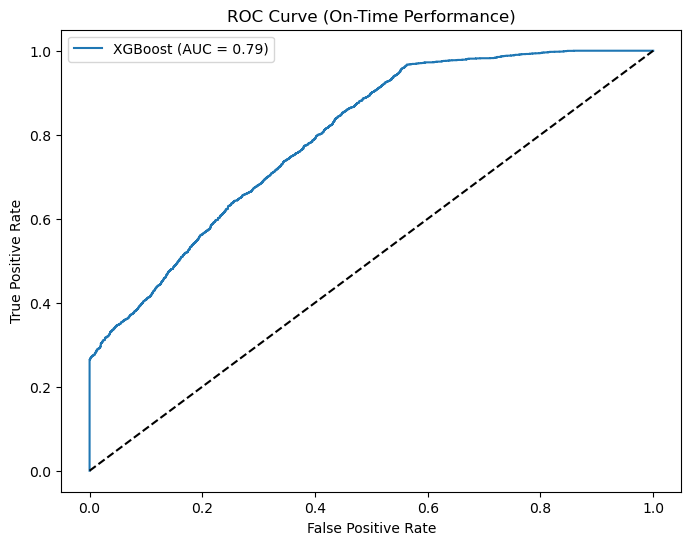

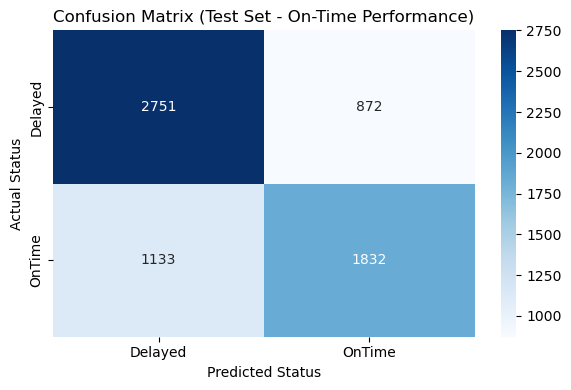

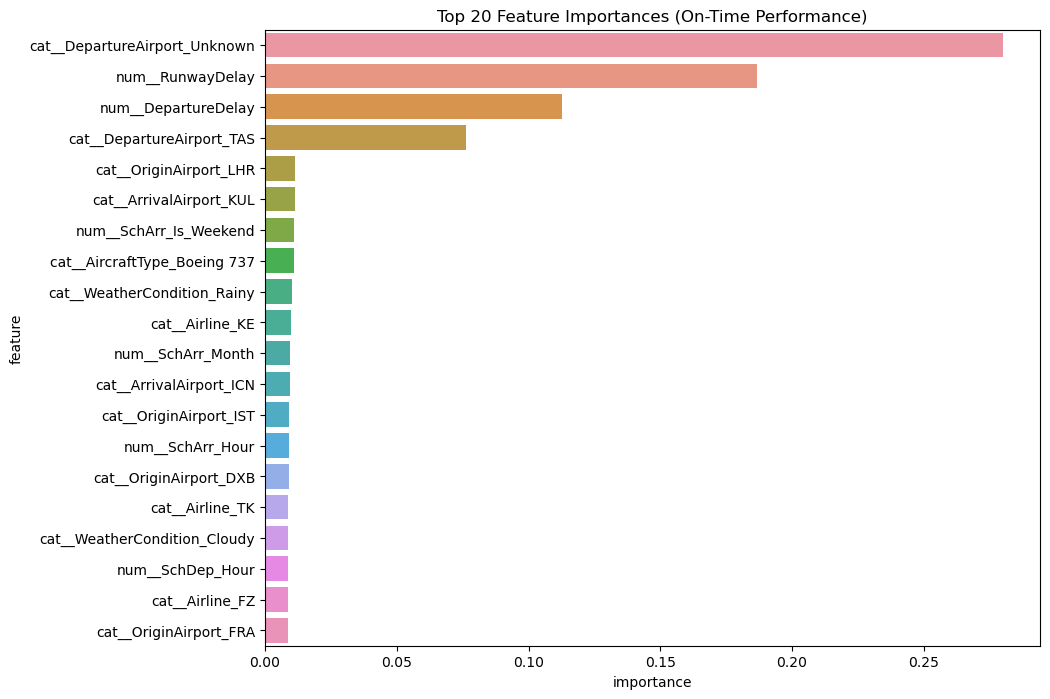

In [6]:

print("\n--- Model Evaluation ---")
y_pred_train_encoded_ontime = xgb_clf_ontime.predict(X_train_processed)
y_pred_test_encoded_ontime = xgb_clf_ontime.predict(X_test_processed)

# Probabilities for ROC AUC (if binary)
if num_target_classes == 2:
    y_pred_proba_test_ontime = xgb_clf_ontime.predict_proba(X_test_processed)[:, 1] # Probability of positive class

# Inverse transform to get original labels for reporting
y_pred_train_labels_ontime = le_ontime.inverse_transform(y_pred_train_encoded_ontime)
y_pred_test_labels_ontime = le_ontime.inverse_transform(y_pred_test_encoded_ontime)
y_train_labels_ontime = le_ontime.inverse_transform(y_train)
y_test_labels_ontime = le_ontime.inverse_transform(y_test)

print("\n--- Training Set Metrics (On-Time Performance) ---")
print(f"Accuracy: {accuracy_score(y_train_labels_ontime, y_pred_train_labels_ontime):.4f}")
print("Classification Report (Training):")
print(classification_report(y_train_labels_ontime, y_pred_train_labels_ontime, zero_division=0))

print("\n--- Test Set Metrics (On-Time Performance) ---")
print(f"Accuracy: {accuracy_score(y_test_labels_ontime, y_pred_test_labels_ontime):.4f}")
print("Classification Report (Test):")
print(classification_report(y_test_labels_ontime, y_pred_test_labels_ontime, zero_division=0))

# ROC AUC for binary classification
if num_target_classes == 2:
    roc_auc = roc_auc_score(y_test, y_pred_proba_test_ontime) # y_test is encoded
    print(f"ROC AUC Score (Test): {roc_auc:.4f}")
    
    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test_ontime)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') # Diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (On-Time Performance)')
    plt.legend()
    plt.show()

# Confusion Matrix (Test Set)
plt.figure(figsize=(6,4))
cm_ontime = confusion_matrix(y_test_labels_ontime, y_pred_test_labels_ontime, labels=le_ontime.classes_)
sns.heatmap(cm_ontime, annot=True, fmt='d', cmap='Blues', xticklabels=le_ontime.classes_, yticklabels=le_ontime.classes_)
plt.title('Confusion Matrix (Test Set - On-Time Performance)')
plt.xlabel('Predicted Status')
plt.ylabel('Actual Status')
plt.tight_layout()
plt.show()

# Feature Importance
if hasattr(xgb_clf_ontime, 'feature_importances_'):
    importances_ontime = xgb_clf_ontime.feature_importances_
    feature_importance_df_ontime = pd.DataFrame({'feature': feature_names_processed_ontime, 'importance': importances_ontime})
    feature_importance_df_ontime = feature_importance_df_ontime.sort_values(by='importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df_ontime)
    plt.title('Top 20 Feature Importances (On-Time Performance)')
    plt.show()



# CRISP-DM Phase: Deployment (Saving Artifacts) 

In [7]:

print("\n--- Saving Artifacts ---")

# 1. Save the Preprocessor
preprocessor_filename_ontime = f"preprocessor_{MODEL_NAME_PREFIX}.pkl"
preprocessor_path_ontime = os.path.join(MODELS_META_DIR, preprocessor_filename_ontime)
joblib.dump(preprocessor_ontime, preprocessor_path_ontime)
print(f"Preprocessor saved to: {preprocessor_path_ontime}")

# 2. Save the list of Processed Feature Names
feature_names_filename_ontime = f"feature_names_{MODEL_NAME_PREFIX}.pkl"
feature_names_path_ontime = os.path.join(MODELS_META_DIR, feature_names_filename_ontime)
joblib.dump(feature_names_processed_ontime, feature_names_path_ontime)
print(f"Feature names saved to: {feature_names_path_ontime}")

# 3. Save the Trained Model (on_time_performance.pkl)
final_model_name_for_dashboard_ontime = "on_time_performance.pkl"
model_path_ontime = os.path.join(MODELS_DIR, final_model_name_for_dashboard_ontime)
joblib.dump(xgb_clf_ontime, model_path_ontime)
print(f"Trained model saved to: {model_path_ontime}")

# LabelEncoder was already saved.

print("\n--- On-Time Performance Modeling Notebook Complete ---")


--- Saving Artifacts ---
Preprocessor saved to: ../models_meta/preprocessor_ontime.pkl
Feature names saved to: ../models_meta/feature_names_ontime.pkl
Trained model saved to: ../models/on_time_performance.pkl

--- On-Time Performance Modeling Notebook Complete ---
